# Correct OCR by (Real) PDF Data

In [1]:
import pprint
from pathlib import Path
import fitz

In [2]:
path_pdf = Path("../../example_pdfs/linking.pdf")
path_pdf.is_file()

True

## PDF2Image

- [Convert PDF(s) into Image(s)](https://pymupdf.readthedocs.io/en/latest/recipes-images.html#how-to-make-images-from-document-pages)

In [42]:
with fitz.open(path_pdf) as doc:
    page = doc[0]
    page_width = int(page.mediabox_size.x)
    page_height = int(page.mediabox_size.y)
    print(f'{page_width = }')
    print(f'{page_height = }')
    zoom_x = 1.5
    zoom_y = zoom_x
    mat = fitz.Matrix(zoom_x, zoom_y)
    pix = page.get_pixmap(matrix=mat)
    
    # dpi = 300
    # pix = page.get_pixmap(dpi=dpi)
pix

page_width = 612
page_height = 792


Pixmap(DeviceRGB, IRect(0, 0, 918, 1188), 0)

In [43]:
FORCE_PNG_SAVE = True
path_png = Path(f'{path_pdf.stem}_page_0.png')
#path_png = path_pdf.parent/f'{path_pdf.stem}_page_0.png'
if not path_png.exists() or FORCE_PNG_SAVE:
    pix.save(path_png)

In [44]:
def print_non_under(obj):
    for s in dir(obj):
        if not s.startswith("_"):
            print(s)

In [45]:
pix.width, pix.height

(918, 1188)

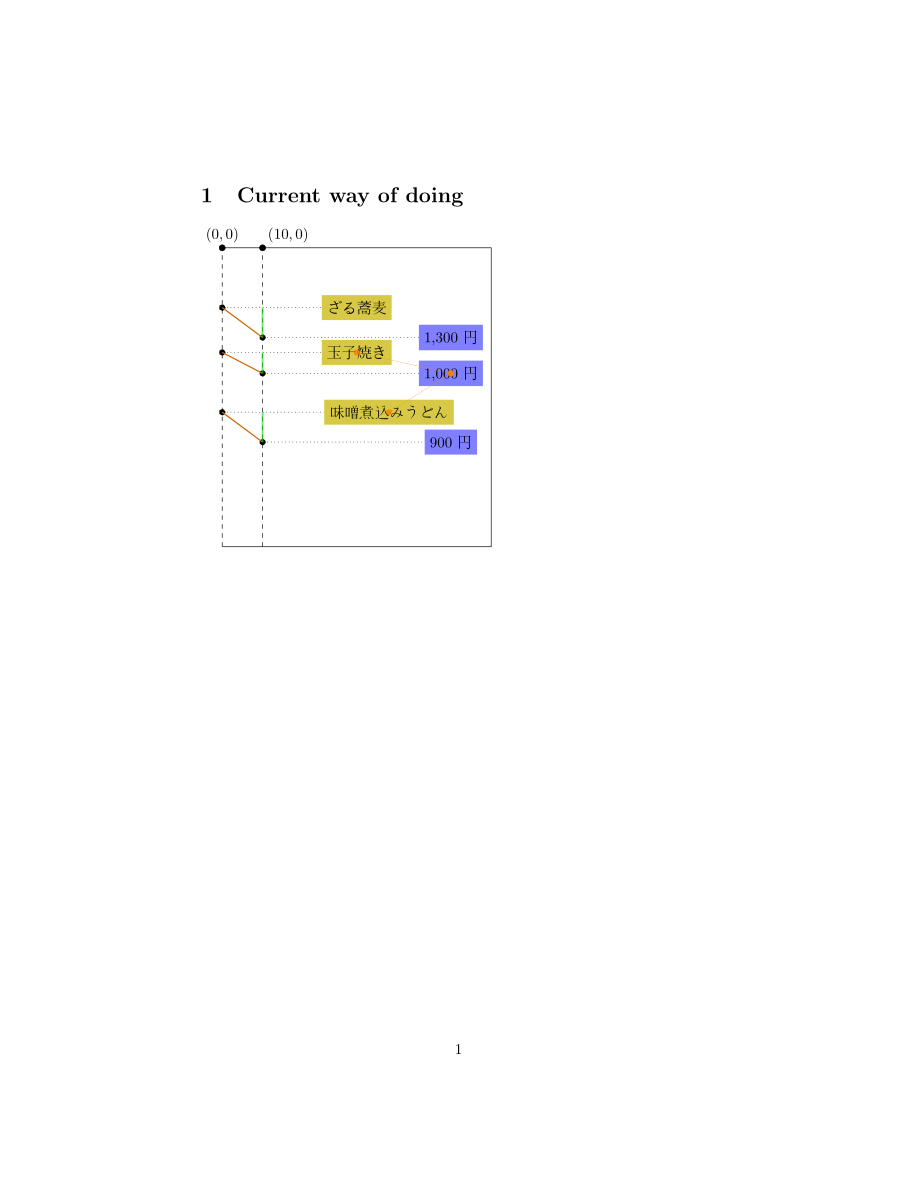

In [46]:
from PIL import Image

image = Image.open(path_png)
image

## OCR

### Tesseract

In [47]:
import pytesseract

In [48]:
ocr_df = pytesseract.image_to_data(image, lang="jpn", output_type="data.frame")
ocr_df

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,1,1,0,0,0,0,0,0,918,1188,-1,NaN
1,2,1,1,0,0,0,238,187,225,20,-1,NaN
2,3,1,1,1,0,0,238,187,225,20,-1,NaN
3,4,1,1,1,1,0,238,187,225,20,-1,NaN
4,5,1,1,1,1,1,238,187,82,16,37,COurrent
5,5,1,1,1,1,2,329,192,40,15,93,way
6,5,1,1,1,1,3,378,187,21,16,92,of
7,5,1,1,1,1,4,406,187,57,20,85,doing
8,2,1,2,0,0,0,203,188,8,14,-1,NaN
9,3,1,2,1,0,0,203,188,8,14,-1,NaN


In [50]:
![ $(uname) = "Darwin" ] && ls /usr/local/Cellar/tesseract/4.1.1/share/tessdata/

configs          jpn.traineddata  pdf.ttf          tessconfigs
eng.traineddata  osd.traineddata  snum.traineddata


Not very good.

In [51]:
ocr_df = ocr_df.assign(
    bottom = lambda x: x.top + x.height,
    right = lambda x: x.left + x.width,
)

In [52]:
ocr_df.head()

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,bottom,right
0,1,1,0,0,0,0,0,0,918,1188,-1,NaN,1188,918
1,2,1,1,0,0,0,238,187,225,20,-1,NaN,207,463
2,3,1,1,1,0,0,238,187,225,20,-1,NaN,207,463
3,4,1,1,1,1,0,238,187,225,20,-1,NaN,207,463
4,5,1,1,1,1,1,238,187,82,16,37,COurrent,203,320


### LINE CLOVA OCR

This OCR result is too noisy: Note that the row with ID equal `1,2,3` refer to the same bbox with text `NaN`.
Let's switch to [LINE CLOVA OCR engine](https://clova.ai/ocr). The JSON OCR result of the image in questions has been downloaded to `./linking_page_0.json`.

In [54]:
import json

path_json = Path("./linking_page_0.json")
with open(path_json, "r", encoding="utf-8") as f:
    ocr_json = json.load(f)

pprint.pprint(ocr_json)

{'lines': [{'boundingBox': [[198, 181], [465, 185], [464, 208], [198, 204]],
            'id': 1,
            'wordIDs': [1, 2, 3, 4, 5]},
           {'boundingBox': [[204, 226], [310, 226], [310, 242], [204, 242]],
            'id': 2,
            'wordIDs': [6, 7]},
           {'boundingBox': [[328, 299], [387, 299], [387, 315], [328, 315]],
            'id': 3,
            'wordIDs': [8]},
           {'boundingBox': [[421, 327], [479, 327], [479, 346], [421, 346]],
            'id': 4,
            'wordIDs': [9, 10]},
           {'boundingBox': [[326, 344], [385, 344], [385, 361], [326, 361]],
            'id': 5,
            'wordIDs': [11]},
           {'boundingBox': [[421, 363], [479, 363], [479, 382], [421, 382]],
            'id': 6,
            'wordIDs': [12, 13]},
           {'boundingBox': [[330, 404], [447, 404], [447, 420], [330, 420]],
            'id': 7,
            'wordIDs': [14]},
           {'boundingBox': [[426, 433], [473, 433], [473, 452], [426, 452]],
        

Note that there exists, although not easy to spot, an OCR error:
- `"味噌煮込みうとん"`: The ground truth should be `"うどん"`, the famous Japanese noodle of "Udon"

This is a very common OCR error -- The Dakuten and Handakuten are hard to get correct for OCR engine.

## Metadata

Real PDFs contain the exact characters appearing in the document as metadata.
Thus, it is wasteful if we do OCR on such documents w/o using these metadata.

In [12]:
with fitz.open(path_pdf) as doc:
    page = doc[0]
    print(f'{page.mediabox = }')
    print(f'{page.mediabox_size = }')
    #print(f'{dir(page.mediabox_size) = }')
    print(f'{page.mediabox_size.x = }')
    print(f'{page.mediabox_size.y = }')

    blocks = page.get_text("words", sort=True)

print()
print("blocks =")
pprint.pprint(blocks)

page.mediabox = Rect(0.0, 0.0, 612.0, 792.0)
page.mediabox_size = Point(612.0, 792.0)
page.mediabox_size.x = 612.0
page.mediabox_size.y = 792.0

blocks =
[(133.76800537109375,
  124.00536346435547,
  141.83056640625,
  138.36590576171875,
  '1',
  0,
  0,
  0),
 (157.98439025878906,
  124.00536346435547,
  213.96327209472656,
  138.36590576171875,
  'Current',
  0,
  1,
  0),
 (219.35743713378906,
  124.00536346435547,
  246.4717559814453,
  138.36590576171875,
  'way',
  0,
  1,
  1),
 (251.8659210205078,
  124.00536346435547,
  264.86358642578125,
  138.36590576171875,
  'of',
  0,
  1,
  2),
 (270.25775146484375,
  124.00536346435547,
  308.8203125,
  138.36590576171875,
  'doing',
  0,
  1,
  3),
 (137.08900451660156,
  151.73703002929688,
  148.70465087890625,
  161.6996307373047,
  '(0,',
  1,
  0,
  0),
 (150.37200927734375,
  151.73703002929688,
  159.2187957763672,
  161.6996307373047,
  '0)',
  1,
  0,
  1),
 (178.5760040283203,
  151.73703002929688,
  195.1726531982422,
  16

## Correction: The Serious Stuff Starts Here

Our goal is implementing a function `corrected_ocr(path_json, path_pdf)`, which is **basically the
same** Python dictionary as the `path_json` with **eventually the text corrected**.

In [62]:
def resize_pdf_bbox(page_words: list, *args, zoom_x: int, zoom_y: int):
    resized_page_words = []
    for x0, y0, x2, y2, text, *unk in page_words:
        resized_page_words.append((
            int(x0*zoom_x),
            int(y0*zoom_y),
            int(x2*zoom_x),
            int(y2*zoom_y),
            text,
            *unk,
        ))
    return resized_page_words


def bbox_type(bbox):
    if isinstance(bbox[0], (int, float)):
        return 2
    elif isinstance(bbox[0], list):
        return 4


def get_iou(bboxA, bboxB):
    typeA = bbox_type(bboxA)
    typeB = bbox_type(bboxB)
    if typeA == 4 and typeB == 2:
        [x0A, y0A], _, [x2A, y2A], _ = bboxA
        x0B, y0B, x2B, y2B = bboxB
    elif typeA == 4 and typeB == 2:
        return get_iou(bboxB, bboxA)

    # x0,y0,x2,y2 represent the intersection of bboxA and bboxB
    x0 = max(x0A, x0B)
    x2 = min(x2A, x2B)
    y0 = max(y0A, y0B)
    y2 = min(y2A, y2B)
    if x0 > x2 or y0 > y2:
        return 0

    area = {}
    area["A"] = (x2A-x0A)*(y2A-y0A)
    area["B"] = (x2B-x0B)*(y2B-y0B)
    area["I"] = (x2-x0)*(y2-y0)
    area["U"] = area["A"] + area["B"] - area["I"]
    try:
        iou = area["I"] / area["U"]
    except ZeroDivisionError as e:
        raise ValueError("Cannot calculate IOU when both bboxA and bboxB have area = 0")

    return iou


def corrected_ocr(*args, path_json, path_pdf, iou_thres: float = 0.8):
    stem = path_json.stem

    try:
        page_no = int(stem.split("_")[-1])
    except ValueError as e:
        print("Double check your path_json's naming. We expect it ends in `..._page_k.json`")
        raise e

    # Info from JSON
    with open(path_json, "r", encoding="utf-8") as f:
        ocr_json = json.load(f)
        ocr_width = ocr_json["meta"]["imageSize"]["width"]
        ocr_height = ocr_json["meta"]["imageSize"]["height"]
        ocr_words = ocr_json["words"]

    # Info from PDF
    with fitz.open(path_pdf) as doc:
        page = doc[page_no]
        page_width = int(page.mediabox_size.x)
        page_height = int(page.mediabox_size.y)
        page_words = page.get_text("words", sort=True)

    zoom_x = ocr_width / page_width
    zoom_y = ocr_height / page_height
    page_words = resize_pdf_bbox(page_words, zoom_x=zoom_x, zoom_y=zoom_y)
    for ocr_word in ocr_words:
        ocr_bbox = ocr_word["boundingBox"]
        ocr_text = ocr_word["text"]
        for page_word in page_words:
            page_bbox = page_word[:4]
            page_text = page_word[4]
            iou = get_iou(ocr_bbox, page_bbox)
            if iou > iou_thres:
                if ocr_text != page_text:
                    print(f'{iou = }')
                    print(f'{ocr_text = }')
                    print(f'{page_text = }')

In [64]:
IOU_THRES = 0.6
#corrected_ocr(path_json=path_json, path_pdf=path_pdf, iou_thres=IOU_THRES)
corrected_ocr(path_json=path_json, path_pdf=path_pdf)

iou = 0.9227129337539433
ocr_text = '味噌煮込みうとん'
page_text = '味噌煮込みうどん'
